In [1]:
using CairoMakie, resistance_evolution, CSV, DataFrames, ColorSchemes, Distributions
CairoMakie.activate!()

┌ Warning: SIMD capacity not detected by ScanByte, using scalar fallback
└ @ ScanByte /Users/tomroeschinger/.julia/packages/ScanByte/cr4PT/src/ScanByte.jl:11


In [2]:
resistance_evolution.plotting_style.default_makie!()

In [3]:
color_dict = Dict(["MG1655", "3.19", "IW", "WTlac", "lacUV5"] .=> ColorSchemes.BuPu_5)
rep_dict = Dict([1, 2] .=> [:circle, :xcross])

Dict{Int64, Symbol} with 2 entries:
  2 => :xcross
  1 => :circle

In [11]:
files = [
    "20220714_r2_allstrains_tc",
    "20220715_r3_allstrains_tc",
    "20220722_r1_allstrains_tc",
    "20220723_r2_allstrains_tc",
    "20220725_r3_allstrains_tc"
    ]

df = DataFrame()

for file in files
    _df = CSV.read(file * "/exp_analysis_summary.csv", DataFrame)
    insertcols!(_df, 5, :tc => map(x -> parse(Float64, split(x, "_")[1]), _df.pos_selection))
    insertcols!(_df, 5, :rep => map(x -> parse(Int64, split(x, "_")[2]), _df.strain))
    insertcols!(_df, 5, :date => parse(Int64, split(file, "_")[1]))
    _df.strain = map(x -> split(x, "_")[1], _df.strain)
    df = vcat(df, _df)
end
first(df, 5)

,run,strain,pos_selection,well,date,rep,tc,exp_growth_rate
,String3,SubStrin…,String15,String3,Int64,Int64,Float64,Float64
1,r2,MG1655,0_µg/ml_tc,A02,20220714,1,0.0,0.00908367
2,r2,3.19,0_µg/ml_tc,A03,20220714,1,0.0,0.00920603
3,r2,IW,0_µg/ml_tc,A04,20220714,1,0.0,0.0103141
4,r2,MG1655,0.1_µg/ml_tc,A05,20220714,1,0.1,0.0074149
5,r2,3.19,0.1_µg/ml_tc,A06,20220714,1,0.1,0.00850656


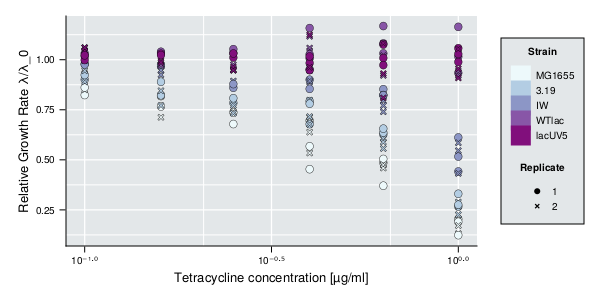

In [23]:
df.strain = map(x -> split(x, "_")[1], df.strain)

fig = Figure(resolution=(600, 300))
ax = Axis(fig[1, 1], xscale=log10)
ax.ylabel = "Relative Growth Rate λ/λ_0"
ax.xlabel = "Tetracycline concentration [µg/ml]"
#ylims!(ax, 0.001, 0.0121)
#vlines!(ax, sort(unique(df.tc)), color="gray", linestyle=:dash, alpha=0.3) 
ax_list = []

for strain in df.strain |> unique
    for run in df[df.strain .== strain, "run"] |> unique
        for rep in [1, 2]
            _df = df[(df.strain .== strain) .& (df.rep .== rep) .& (df.run .== run), :]
            df_λ_0 = combine(groupby(_df[_df.tc .== 0, :], :date), :exp_growth_rate => mean)
            df_comb = combine(groupby(_df[_df.tc .> 0, :], [:tc, :date]), :exp_growth_rate => mean)
            insertcols!(df_comb,  1, :rel_growth_rate => 0.)
            for date in df_λ_0.date |> unique
                df_comb[df_comb.date .== date, :rel_growth_rate] = df_comb[df_comb.date .== date, :exp_growth_rate_mean] ./ 
                df_λ_0[df_λ_0.date .== date, :exp_growth_rate_mean]
            end
            scatter!(
                ax,
                df_comb.tc,
                df_comb[!, :rel_growth_rate],
                strokewidth=0.4,
                strokecolor="black",
                markersize=10,
                color=(color_dict[strain], 1),
                marker=rep_dict[rep]
                )
        end
    end
end

marker_list = [MarkerElement(marker = marker, color = :black,
    strokecolor = :transparent,
    markersize = 8) for marker in [:circle, :xcross]]

color_list = [PolyElement(color = color) for color in ColorSchemes.BuPu_5]

l = Legend(fig,
    [color_list, marker_list],
    [["MG1655", "3.19", "IW", "WTlac", "lacUV5"], string.([1, 2])],
    ["Strain", "Replicate"])

fig[1, 2] = l




save("tc_lambda.pdf", fig)
fig
    

In [24]:
combine(groupby(df[df.tc .== 0, :], [:run, :rep, :strain]), :exp_growth_rate => mean)

,run,rep,strain,exp_growth_rate_mean
,String3,Int64,SubStrin…,Float64
1,r2,1,MG1655,0.00927155
2,r2,1,3.19,0.00958789
3,r2,1,IW,0.0102642
4,r2,1,WTlac,0.00991646
5,r2,1,lacUV5,0.0100891
6,r2,2,MG1655,0.0100109
7,r2,2,3.19,0.0100383
8,r2,2,IW,0.0102285
9,r2,2,WTlac,0.00987716


In [31]:
CSV.read("../../data/plate_reader/20220722_r1_allstrains_tc/20220722_r1_allstrains_tc.txt", DataFrame)

,0:06:10,37.0,0.038,0.067,0.069,0.062,0.066,0.068
,Time,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,00:13:10,36.9,0.038,0.067,0.07,0.063,0.067,0.069
2,00:20:10,37.0,0.038,0.069,0.071,0.065,0.068,0.07
3,00:27:10,37.0,0.038,0.07,0.072,0.066,0.069,0.071
4,00:34:10,37.0,0.038,0.072,0.074,0.067,0.07,0.073
5,00:41:10,37.1,0.038,0.073,0.076,0.069,0.071,0.074
6,00:48:10,37.0,0.038,0.075,0.078,0.071,0.071,0.076
7,00:55:10,37.0,0.038,0.078,0.081,0.072,0.072,0.078
8,01:02:10,37.0,0.038,0.08,0.083,0.075,0.074,0.08
9,01:09:10,37.0,0.038,0.083,0.086,0.077,0.075,0.081


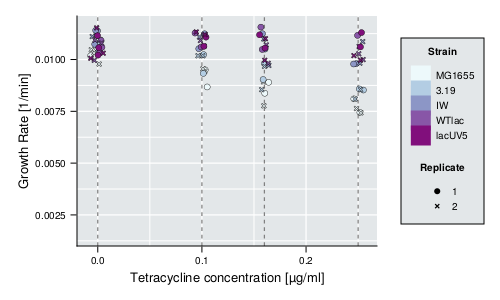

In [7]:
df = CSV.read("20220715_r3_allstrains_tc/exp_analysis_summary.csv", DataFrame)
insertcols!(df, 5, :tc => map(x -> parse(Float64, split(x, "_")[1]), df.pos_selection))
fig = Figure(resolution=(500, 300))

insertcols!(df, 5, :rep => map(x -> parse(Int64, split(x, "_")[2]), df.strain))

df.strain = map(x -> split(x, "_")[1], df.strain)

ax = Axis(fig[1, 1])
ax.ylabel = "Growth Rate [1/min]"
ax.xlabel = "Tetracycline concentration [µg/ml]"
ylims!(ax, 0.001, 0.0121)
vlines!(ax, [0, 0.1, 0.16, 0.25], color="gray", linestyle=:dash, alpha=0.3) 
ax_list = []

for strain in df.strain |> unique
    for rep in [1, 2]
        _df = df[(df.strain .== strain) .& (df.rep .== rep), :]
        scatter!(
            ax,
            _df.tc .+ rand(Normal(0, 0.003), length(_df.tc)),
            _df.exp_growth_rate,
            strokewidth=0.4,
            strokecolor="black",
            markersize=8,
            color=(color_dict[strain], 1),
            marker=rep_dict[rep]
            )
    end
end

marker_list = [MarkerElement(marker = marker, color = :black,
    strokecolor = :transparent,
    markersize = 8) for marker in [:circle, :xcross]]

color_list = [PolyElement(color = color) for color in ColorSchemes.BuPu_5]

l = Legend(fig,
    [color_list, marker_list],
    [["MG1655", "3.19", "IW", "WTlac", "lacUV5"], string.([1, 2])],
    ["Strain", "Replicate"])

fig[1, 2] = l




save("tc_lambda_2.pdf", fig)
fig
    